In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import pylab as pl
import shapely
import os
import statsmodels as stm
import urllib2
import urllib
import StringIO
import ast
from datetime import datetime, timedelta
import time
import io
import json
import requests
import shutil
import datetime as dt
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
from sklearn import preprocessing
import statsmodels.formula.api as smf
import pytz as pytz

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


---

# WEATHER

In [13]:
# Downloadind the weather data - don't run again
#!unzip "DarkSky_Data.zip"

Archive:  DarkSky_Data.zip
  inflating: DarkSky_Data.json       


In [3]:
# Reading in the weather 

weather = pd.read_json("DarkSky_Data.json")

In [4]:
weather.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed
0,26.80,0.82,28.43,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1009.73,Mostly Cloudy,32.48,1136091600,8.84,335.0,6.00
1,27.04,0.77,28.32,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1010.35,Mostly Cloudy,32.33,1136095200,7.67,345.0,5.49
2,27.21,0.78,28.34,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1011.40,Mostly Cloudy,32.29,1136098800,8.69,344.0,5.23
3,27.01,0.34,27.97,0.84,partly-cloudy-night,NaN,0.0,0.0,NaN,1012.17,Partly Cloudy,32.19,1136102400,8.79,345.0,5.32
4,26.65,0.95,28.10,0.85,cloudy,NaN,0.0,0.0,NaN,1012.67,Overcast,32.00,1136106000,8.41,339.0,5.49


In [5]:
# # Adding datetime column to weather data

weather['datetime'] = pd.to_datetime(weather['time'], unit='s', utc=True)

In [6]:
# Adjusting the datetime for timezone 

tz = pytz.timezone('America/New_York')

adjustDateTime = []
for i in range(len(weather)):
    adjustDateTime.append(weather['datetime'][i].tz_localize(pytz.utc).tz_convert(tz).tz_localize(None))

In [7]:
# Adding the adjusted column

weather['datetime_adj'] = adjustDateTime

In [8]:
# Reweather.head()

In [9]:
# Removing duplicated rows

weather = weather.drop_duplicates(subset=['datetime_adj'])

---

# CRIME

In [8]:
## Downloading the crime data -- very large, don't run again

#!wget "https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD"

--2018-02-12 22:32:08--  https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us... 52.206.140.205
Connecting to data.cityofnewyork.us|52.206.140.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: “rows.csv?accessType=DOWNLOAD”

    [               <=>                   ] 1,427,270,109 2.71M/s   in 10m 33s 

Last-modified header invalid -- time-stamp ignored.
2018-02-12 22:42:43 (2.15 MB/s) - “rows.csv?accessType=DOWNLOAD” saved [1427270109]



In [10]:
# Reading in the crime data

crimeData = pd.read_csv("rows.csv_accessType=DOWNLOAD")

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# Looking through the columns

crimeData.columns

Index([u'CMPLNT_NUM', u'CMPLNT_FR_DT', u'CMPLNT_FR_TM', u'CMPLNT_TO_DT',
       u'CMPLNT_TO_TM', u'RPT_DT', u'KY_CD', u'OFNS_DESC', u'PD_CD',
       u'PD_DESC', u'CRM_ATPT_CPTD_CD', u'LAW_CAT_CD', u'JURIS_DESC',
       u'BORO_NM', u'ADDR_PCT_CD', u'LOC_OF_OCCUR_DESC', u'PREM_TYP_DESC',
       u'PARKS_NM', u'HADEVELOPT', u'X_COORD_CD', u'Y_COORD_CD', u'Latitude',
       u'Longitude', u'Lat_Lon'],
      dtype='object')

In [83]:
crimeData.PREM_TYP_DESC.unique()

array(['BAR/NIGHT CLUB', nan, 'OTHER', 'RESIDENCE-HOUSE', 'DRUG STORE',
       'STREET', 'RESIDENCE - APT. HOUSE', 'FAST FOOD', 'RESTAURANT/DINER',
       'DRY CLEANER/LAUNDRY', 'PUBLIC BUILDING',
       'RESIDENCE - PUBLIC HOUSING', 'PARK/PLAYGROUND',
       'PARKING LOT/GARAGE (PUBLIC)', 'GAS STATION', 'TUNNEL',
       'CHAIN STORE', 'CHECK CASHING BUSINESS', 'TRANSIT - NYC SUBWAY',
       'BUS (NYC TRANSIT)', 'BEAUTY & NAIL SALON', 'GROCERY/BODEGA',
       'COMMERCIAL BUILDING', 'FOOD SUPERMARKET', 'HOTEL/MOTEL',
       'SMALL MERCHANT', 'CHURCH', 'PARKING LOT/GARAGE (PRIVATE)',
       'DEPARTMENT STORE', 'STORE UNCLASSIFIED', 'GYM/FITNESS FACILITY',
       'VARIETY STORE', 'CLOTHING/BOUTIQUE', 'FERRY/FERRY TERMINAL',
       'DOCTOR/DENTIST OFFICE', 'TELECOMM. STORE', 'JEWELRY',
       'CONSTRUCTION SITE', 'BUS STOP', 'BANK', 'HOSPITAL',
       'TAXI (LIVERY LICENSED)', 'ATM', 'BRIDGE',
       'PRIVATE/PAROCHIAL SCHOOL', 'SOCIAL CLUB/POLICY', 'CANDY STORE',
       'FACTORY/WAREHOUSE

In [82]:
crimeData.PREM_TYP_DESC.value_counts()

STREET                          1841239
RESIDENCE - APT. HOUSE          1158315
RESIDENCE-HOUSE                  549568
RESIDENCE - PUBLIC HOUSING       419936
OTHER                            148410
COMMERCIAL BUILDING              144019
TRANSIT - NYC SUBWAY             117859
DEPARTMENT STORE                 107343
CHAIN STORE                      107217
PUBLIC SCHOOL                     71369
PARK/PLAYGROUND                   66910
GROCERY/BODEGA                    63868
RESTAURANT/DINER                  62655
BAR/NIGHT CLUB                    62573
CLOTHING/BOUTIQUE                 46040
DRUG STORE                        42202
PUBLIC BUILDING                   35437
PARKING LOT/GARAGE (PUBLIC)       32031
PARKING LOT/GARAGE (PRIVATE)      31617
FOOD SUPERMARKET                  29703
HOSPITAL                          26064
STORE UNCLASSIFIED                25614
FAST FOOD                         25516
SMALL MERCHANT                    23747
BANK                              23412


In [12]:
crimeData.tail()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
5580030,582350583,01/01/2015,03:50:00,01/01/2016,04:00:00,01/01/2016,105,ROBBERY,399.0,"ROBBERY,COMMERCIAL UNCLASSIFIED",...,30.0,INSIDE,HOTEL/MOTEL,NaN,NaN,998372.0,240146.0,40.825818,-73.948975,"(40.825817778, -73.948974825)"
5580031,258046495,01/01/2015,01:25:00,01/01/2016,01:30:00,01/01/2016,578,HARRASSMENT 2,638.0,"HARASSMENT,SUBD 3,4,5",...,41.0,NaN,TRANSIT - NYC SUBWAY,NaN,NaN,1014468.0,238156.0,40.820315,-73.890825,"(40.820315396, -73.890824603)"
5580032,640212578,01/01/2015,00:30:00,01/01/2016,00:40:00,01/01/2016,106,FELONY ASSAULT,109.0,"ASSAULT 2,1,UNCLASSIFIED",...,109.0,FRONT OF,BAR/NIGHT CLUB,NaN,NaN,1030529.0,214093.0,40.754199,-73.832963,"(40.754199468, -73.832962523)"
5580033,496500431,06/30/2014,12:00:00,12/29/2015,12:00:00,01/01/2016,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,AGGRAVATED HARASSMENT 2,...,50.0,INSIDE,RESIDENCE - APT. HOUSE,NaN,NaN,1009735.0,261272.0,40.883777,-73.907837,"(40.883776851, -73.907836928)"
5580034,256379572,12/31/2001,16:00:00,01/01/2016,10:50:00,01/01/2016,107,BURGLARY,213.0,"BURGLARY,COMMERCIAL,NIGHT",...,84.0,INSIDE,PUBLIC SCHOOL,NaN,NaN,989682.0,188334.0,40.683617,-73.980416,"(40.683616638, -73.980416007)"


In [13]:
# Filtering down to complaint dates between 01/01/2006 - 12/31/2017

crimeData['year'] = crimeData['CMPLNT_FR_DT'].str[-4:].fillna(0).astype(int)
crimeData['hour'] = crimeData['CMPLNT_FR_TM'].str[:2].fillna(0).astype(int)
crime = crimeData[((crimeData['year'] > 2005) & (crimeData['hour'] < 24))]

# Creating datetime column

crime['datetime'] = pd.to_datetime((crime['CMPLNT_FR_DT'] + ' ' + crime['CMPLNT_FR_TM']), format='%m/%d/%Y %H:%M:%S')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# dropping NaNs from datetime

crime = crime.dropna(axis=0, subset=['datetime'])
crime = crime.reset_index()

In [15]:
# Rounding to the nearest hour

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

crimeRound = []

for i in range(len(crime)):
     t = crime['datetime'][i]
     crimeRound.append(hour_rounder(t)) 

In [16]:
# Adding the rounded datetime to the dataframe

crime['datetime_round'] = crimeRound

In [17]:
crime.head()

,index,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon,year,hour,datetime,datetime_round
0,0,101109527,12/31/2015,23:45:00,NaN,NaN,12/31/2015,113,FORGERY,729.0,...,NaN,1007314.0,241257.0,40.828848,-73.916661,"(40.828848333, -73.916661142)",2015,23,2015-12-31 23:45:00,2016-01-01 00:00:00
1,1,153401121,12/31/2015,23:36:00,NaN,NaN,12/31/2015,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,1043991.0,193406.0,40.697338,-73.784557,"(40.697338138, -73.784556739)",2015,23,2015-12-31 23:36:00,2016-01-01 00:00:00
2,2,569369778,12/31/2015,23:30:00,NaN,NaN,12/31/2015,117,DANGEROUS DRUGS,503.0,...,NaN,999463.0,231690.0,40.802607,-73.945052,"(40.802606608, -73.945051911)",2015,23,2015-12-31 23:30:00,2016-01-01 00:00:00
3,3,968417082,12/31/2015,23:30:00,NaN,NaN,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,NaN,1060183.0,177862.0,40.654549,-73.726339,"(40.654549444, -73.726338791)",2015,23,2015-12-31 23:30:00,2016-01-01 00:00:00
4,4,641637920,12/31/2015,23:25:00,12/31/2015,23:30:00,12/31/2015,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,NaN,987606.0,208148.0,40.738002,-73.987891,"(40.7380024, -73.98789129)",2015,23,2015-12-31 23:25:00,2015-12-31 23:00:00


In [18]:
# Unique crime types

crimeData.OFNS_DESC.unique()

array(['FORGERY', 'MURDER & NON-NEGL. MANSLAUGHTER', 'DANGEROUS DRUGS',
       'ASSAULT 3 & RELATED OFFENSES', 'FELONY ASSAULT',
       'DANGEROUS WEAPONS', 'PETIT LARCENY', 'GRAND LARCENY', 'ROBBERY',
       'OFFENSES AGAINST PUBLIC ADMINI', 'CRIMINAL MISCHIEF & RELATED OF',
       'RAPE', 'INTOXICATED & IMPAIRED DRIVING', 'HARRASSMENT 2',
       'SEX CRIMES', 'BURGLARY', 'CRIMINAL TRESPASS',
       'MISCELLANEOUS PENAL LAW', 'VEHICLE AND TRAFFIC LAWS',
       'OFF. AGNST PUB ORD SENSBLTY &', 'FRAUDS',
       'GRAND LARCENY OF MOTOR VEHICLE', 'OFFENSES INVOLVING FRAUD',
       'OFFENSES AGAINST THE PERSON', 'FRAUDULENT ACCOSTING',
       'OTHER OFFENSES RELATED TO THEF', 'GAMBLING', 'ARSON',
       'POSSESSION OF STOLEN PROPERTY', 'UNAUTHORIZED USE OF A VEHICLE',
       'THEFT-FRAUD', 'DISORDERLY CONDUCT', nan, 'ADMINISTRATIVE CODE',
       'CHILD ABANDONMENT/NON SUPPORT', 'OTHER STATE LAWS (NON PENAL LA',
       'NYS LAWS-UNCLASSIFIED FELONY', "BURGLAR'S TOOLS",
       'THEFT OF SERV

---

# Merging the Data

In [19]:
df = crime.merge(weather, how='left', left_on="datetime_round", right_on="datetime_adj")

In [20]:
# Confirming that the new dataframe is the same length as the crime dataframe

print("left merge:", len(df) - len(crime))

left merge: 0


In [21]:
df.columns

Index([              u'index',          u'CMPLNT_NUM',        u'CMPLNT_FR_DT',
              u'CMPLNT_FR_TM',        u'CMPLNT_TO_DT',        u'CMPLNT_TO_TM',
                    u'RPT_DT',               u'KY_CD',           u'OFNS_DESC',
                     u'PD_CD',             u'PD_DESC',    u'CRM_ATPT_CPTD_CD',
                u'LAW_CAT_CD',          u'JURIS_DESC',             u'BORO_NM',
               u'ADDR_PCT_CD',   u'LOC_OF_OCCUR_DESC',       u'PREM_TYP_DESC',
                  u'PARKS_NM',          u'HADEVELOPT',          u'X_COORD_CD',
                u'Y_COORD_CD',            u'Latitude',           u'Longitude',
                   u'Lat_Lon',                u'year',                u'hour',
                u'datetime_x',      u'datetime_round', u'apparentTemperature',
                u'cloudCover',            u'dewPoint',            u'humidity',
                      u'icon',  u'precipAccumulation',     u'precipIntensity',
         u'precipProbability',          u'precipType

In [22]:
df = df.round({'dewPoint':0, 'apparentTemperature':0, 'temperature': 0, 'visibility': 1, 
               'windBearing': 0, 'windSpeed': 0, 'pressure':0, 'precipAccumulation':2 })

In [23]:
# Reducing df to the 7 major felony types

sevenFelonies = ['ROBBERY', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER', 'GRAND LARCENY', 'BURGLARY',
                 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']
dfSeven = df.loc[df['OFNS_DESC'].isin(sevenFelonies)].reset_index()

# Plotting the data

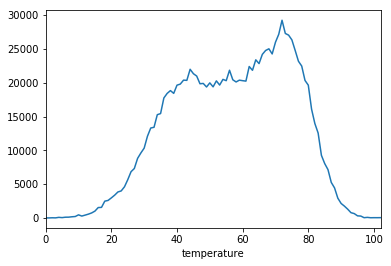

In [24]:
dfSeven.groupby('temperature').size().plot();

In [37]:
dfSeven['temperature'].min()

0.0

In [25]:
dfCrimesByTemp = dfSeven.groupby('temperature').size()
dfCrimesByTemp = pd.DataFrame(dfCrimesByTemp).reset_index()
dfCrimesByTemp.columns = ['Temperature', 'Count_crime']
dfCrimesByTemp.head()

,Temperature,Count_crime
0,0.0,4
1,1.0,3
2,2.0,23
3,3.0,12
4,4.0,86


In [26]:
dfTempNorm = dfSeven.groupby(['temperature','datetime_adj']).size()
dfTempNorm = pd.DataFrame(dfTempNorm).reset_index()
dfTempByHour = dfTempNorm.groupby('temperature').size()
dfTempByHour = pd.DataFrame(dfTempByHour).reset_index()
dfTempByHour.columns = ['Temperature', 'Count_hour']
dfTempByHour.head()

,Temperature,Count_hour
0,0.0,1
1,1.0,1
2,2.0,4
3,3.0,3
4,4.0,12


In [27]:
dfTempNormalized = pd.merge(dfTempByHour, dfCrimesByTemp, on='Temperature')

In [28]:
dfTempNormalized['avgCrimePerHour'] = dfTempNormalized.Count_crime / dfTempNormalized.Count_hour

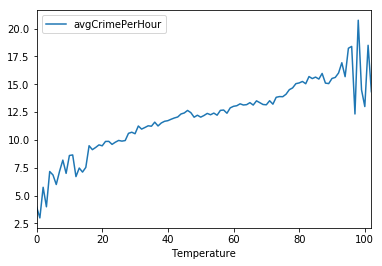

In [29]:
dfTempNormalized.plot('Temperature', 'avgCrimePerHour')

In [30]:
tempMod = smf.ols("avgCrimePerHour ~ Temperature", data=dfTempNormalized)
tempFit = tempMod.fit()
tempFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        avgCrimePerHour   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     630.0
Date:                Sun, 15 Apr 2018   Prob (F-statistic):           3.32e-45
Time:                        10:41:54   Log-Likelihood:                -164.10
No. Observations:                 103   AIC:                             332.2
Df Residuals:                     101   BIC:                             337.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       6.9062      0.235     29.367      0.000         6.440     7.373
Temperature     0.1000      0.004     25.099      0.000         0.092     0.108
==============================================================================
Omnibus:                       33.966   Durbin-Watson:                   1.700
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.103
Skew:                          -1.177   Prob(JB):                     7.39e-20
Kurtosis:                       6.872   Cond. No.                         117.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

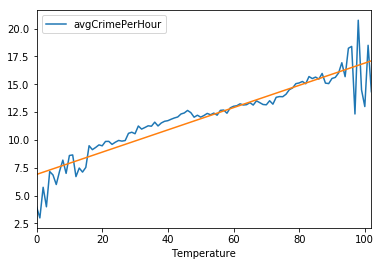

In [31]:
dfTempNormalized.plot('Temperature', 'avgCrimePerHour')
tempFitLine = tempFit.fittedvalues
pl.plot(tempFitLine);

In [62]:
# Defining our function

def weatherCorrelation (dataframe, crime, weatherType):
    
    """Does all of the above, but allows us to specify the specific crime type and weather type"""
    
    # Reducing dataframe based on selected crime type (listing no crime yields all results
    if crime == 'ALL CRIME':
        dataframe = dataframe
    else:
        dataframe = dataframe.loc[dataframe['OFNS_DESC'] == crime]
    
    ### NEW CODE
    
    # Removing weather outliers - first and last fifth
    
    #outCount = ((dataframe[weatherType].max() - dataframe[weatherType].min()) / 5)
    #weatherMin = dataframe[weatherType].min() + outCount
    #weatherMax = dataframe[weatherType].max() - outCount
    
    #dataframe = dataframe[(dataframe[weatherType] >= weatherMin) & (dataframe[weatherType] <= weatherMax)]
    
    ### END OF NEW CODE
    
    # Reducing crime type by weather event
    
    dfCrimesByWeather = dataframe.groupby(weatherType).size()
    dfCrimesByWeather = pd.DataFrame(dfCrimesByWeather).reset_index()
    dfCrimesByWeather.columns = [weatherType, 'Count_crime']
    
    # Calculating number of hours of each weather pattern
    
    dfWeatherNorm = dataframe.groupby([weatherType,'datetime_adj']).size()
    dfWeatherNorm = pd.DataFrame(dfWeatherNorm).reset_index()
    dfWeatherByHour = dfWeatherNorm.groupby(weatherType).size()
    dfWeatherByHour = pd.DataFrame(dfWeatherByHour).reset_index()
    dfWeatherByHour.columns = [weatherType, 'Count_hour']

    # Getting average Crime per Hour
    
    dfWeatherNormalized = pd.merge(dfCrimesByWeather, dfWeatherByHour, on=weatherType)
    dfWeatherNormalized['CrimePerHour'] = dfWeatherNormalized.Count_crime / dfWeatherNormalized.Count_hour
    
    # Fit a regression model
    
    weatherMod = smf.ols("CrimePerHour ~ " + weatherType, data=dfWeatherNormalized)
    weatherFit = weatherMod.fit()
    weatherFitLine = weatherFit.fittedvalues
    
    x = weatherFit.summary()
    y = dfWeatherNormalized.plot(weatherType, 'CrimePerHour', title=crime, legend=False)
    z = pl.plot(weatherFitLine);
    
    print("\n\n" + crime + " Regression Results:\n\n\n", x)
    return y, z

# Using the formula for different weather types



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     630.0
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           3.32e-45
Time:                        14:34:54   Log-Likelihood:                -164.10
No. Observations:                 103   AIC:                             332.2
Df Residuals:                     101   BIC:                             337.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     89.55
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           1.62e-15
Time:                        14:34:57   Log-Likelihood:                -17.243
No. Observations:                 101   AIC:                             38.49
Df Residuals:                      99   BIC:                             43.72
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       

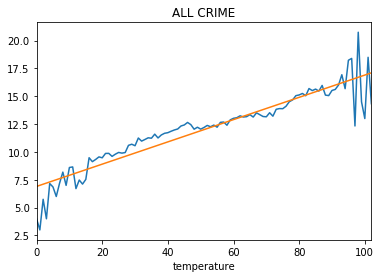

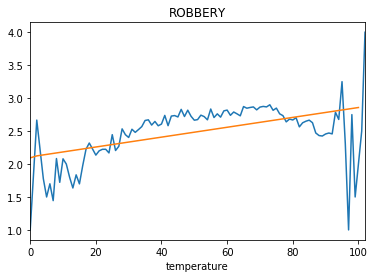

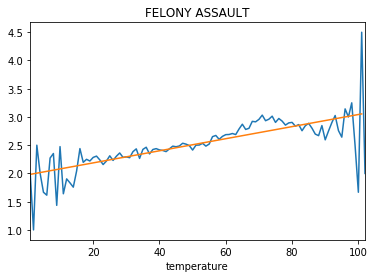

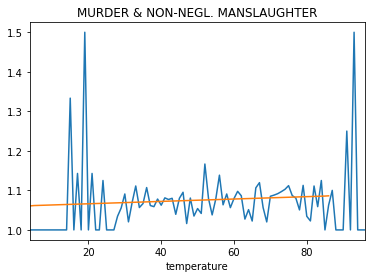

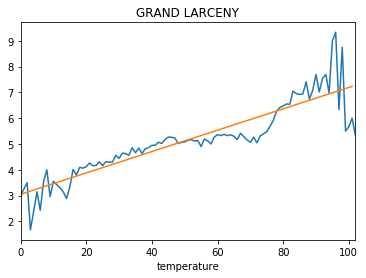

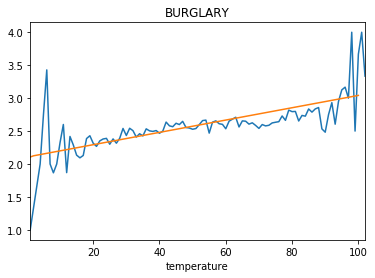

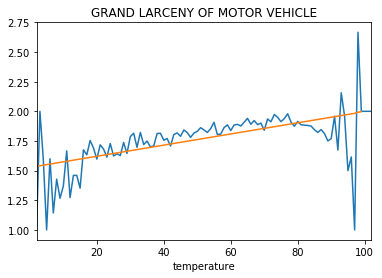

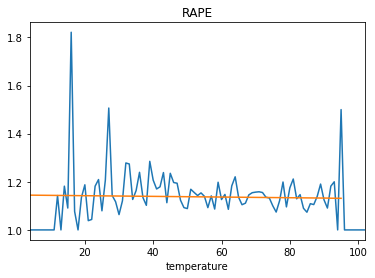

In [63]:
felonyTypes = ['ALL CRIME', 'ROBBERY', 'FELONY ASSAULT', 'MURDER & NON-NEGL. MANSLAUGHTER', 'GRAND LARCENY', 'BURGLARY',
                 'GRAND LARCENY OF MOTOR VEHICLE', 'RAPE']

weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'temperature')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     611.3
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           5.53e-51
Time:                        14:34:59   Log-Likelihood:                -232.13
No. Observations:                 132   AIC:                             468.3
Df Residuals:                     130   BIC:                             474.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     108.3
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           8.66e-19
Time:                        14:35:02   Log-Likelihood:                -36.222
No. Observations:                 131   AIC:                             76.44
Df Residuals:                     129   BIC:                             82.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------


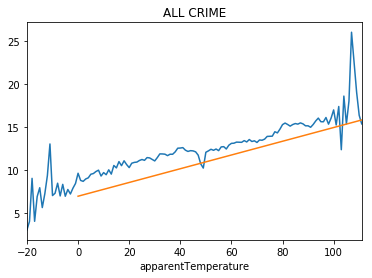

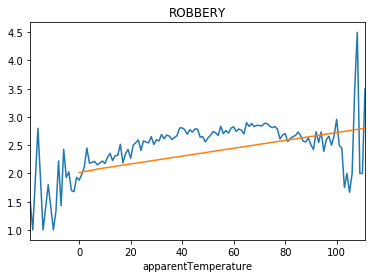

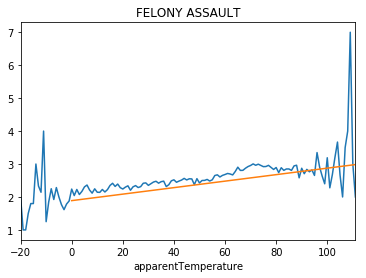

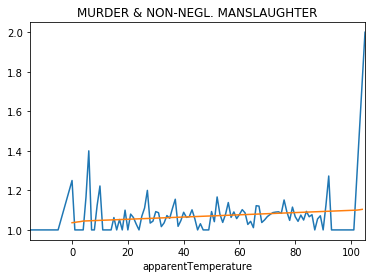

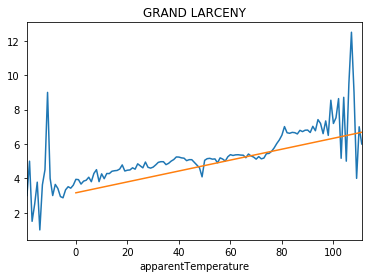

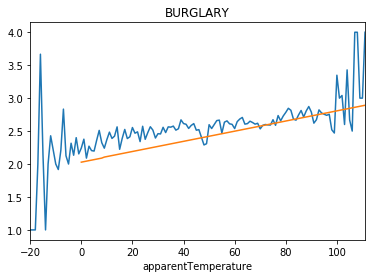

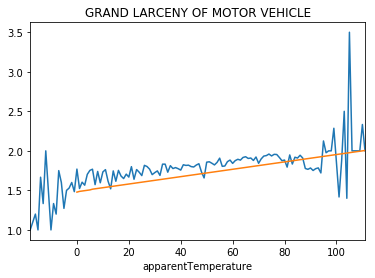

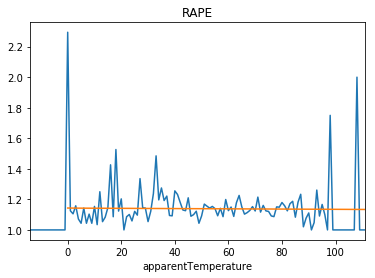

In [64]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'apparentTemperature')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     354.3
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           1.20e-33
Time:                        14:35:04   Log-Likelihood:                -109.04
No. Observations:                  96   AIC:                             222.1
Df Residuals:                      94   BIC:                             227.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     70.78
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           4.62e-13
Time:                        14:35:06   Log-Likelihood:                 20.462
No. Observations:                  95   AIC:                            -36.92
Df Residuals:                      93   BIC:                            -31.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.3

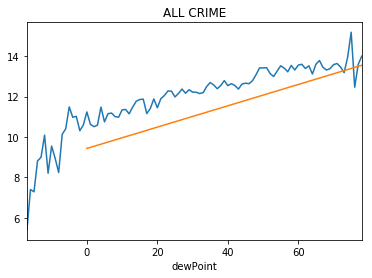

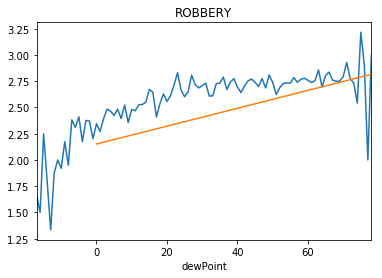

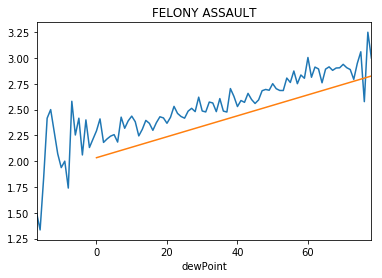

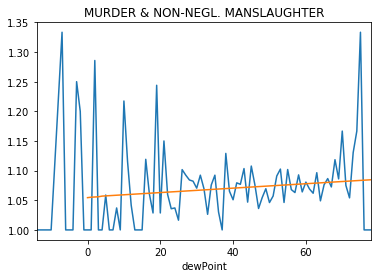

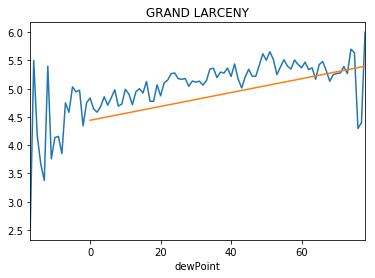

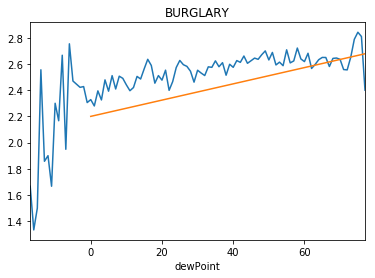

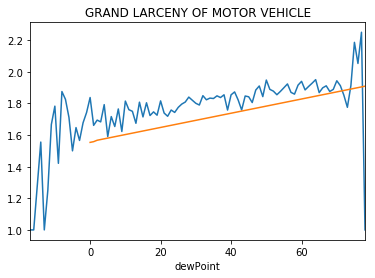

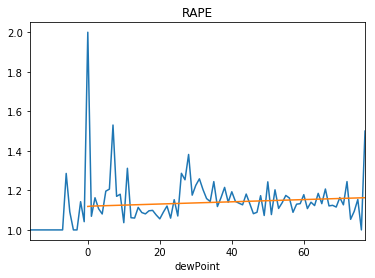

In [65]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'dewPoint')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     54.07
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           5.92e-11
Time:                        14:35:07   Log-Likelihood:                -116.23
No. Observations:                 100   AIC:                             236.5
Df Residuals:                      98   BIC:                             241.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     10.



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                 0.0005440
Date:                Mon, 16 Apr 2018   Prob (F-statistic):              0.981
Time:                        14:35:10   Log-Likelihood:                 26.687
No. Observations:                 100   AIC:                            -49.37
Df Residuals:                      98   BIC:                            -44.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.6

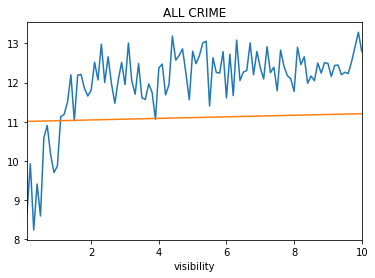

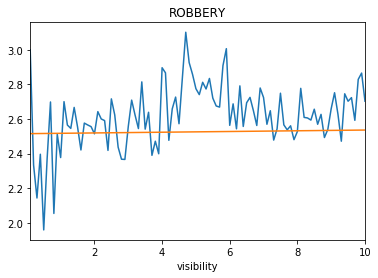

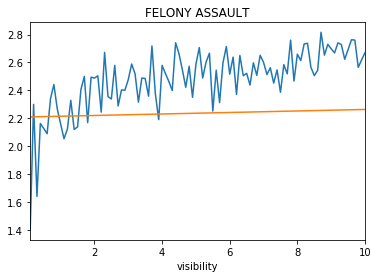

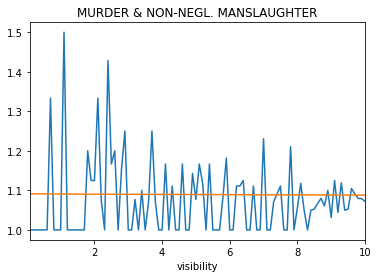

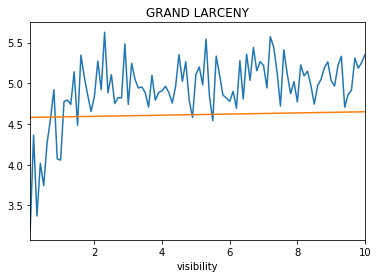

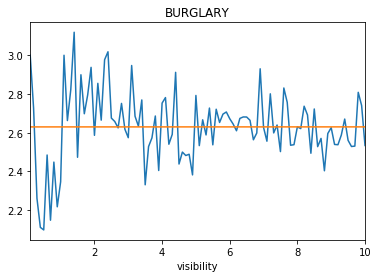

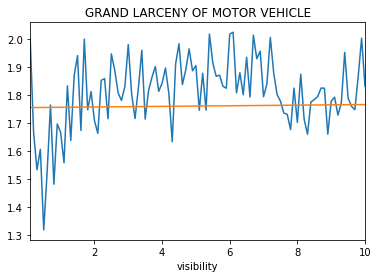

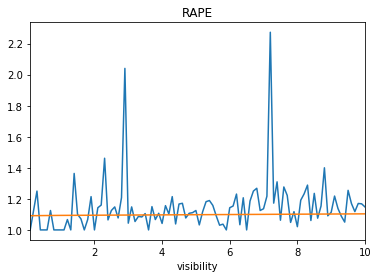

In [66]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'visibility')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.041
Date:                Mon, 16 Apr 2018   Prob (F-statistic):             0.0141
Time:                        14:35:11   Log-Likelihood:                -4743.0
No. Observations:                1653   AIC:                             9490.
Df Residuals:                    1651   BIC:                             9501.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Interce



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 0.0003791
Date:                Mon, 16 Apr 2018   Prob (F-statistic):              0.984
Time:                        14:35:14   Log-Likelihood:                -2540.7
No. Observations:                1558   AIC:                             5085.
Df Residuals:                    1556   BIC:                             5096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercep

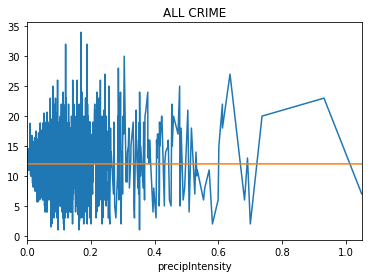

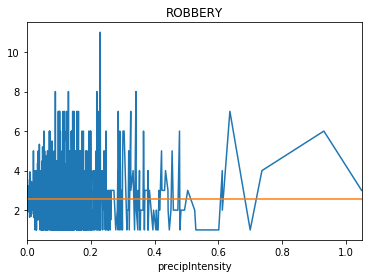

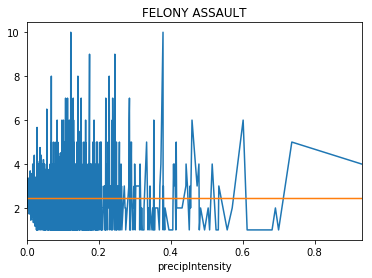

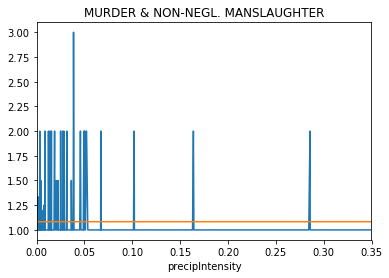

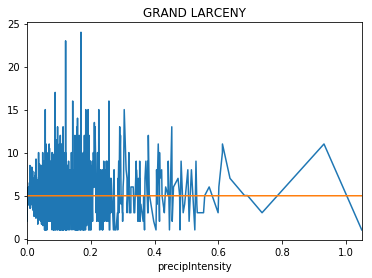

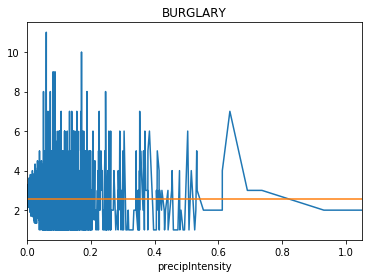

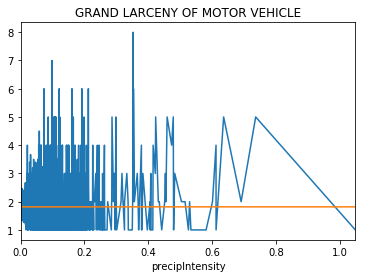

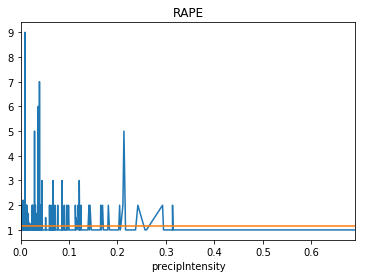

In [67]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'precipIntensity')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1578
Date:                Mon, 16 Apr 2018   Prob (F-statistic):              0.691
Time:                        14:35:16   Log-Likelihood:                -496.78
No. Observations:                 360   AIC:                             997.6
Df Residuals:                     358   BIC:                             1005.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     23.80
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           1.61e-06
Time:                        14:35:19   Log-Likelihood:                 213.15
No. Observations:                 360   AIC:                            -422.3
Df Residuals:                     358   BIC:                            -414.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       

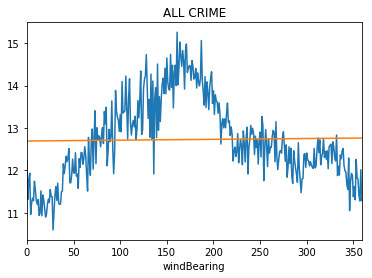

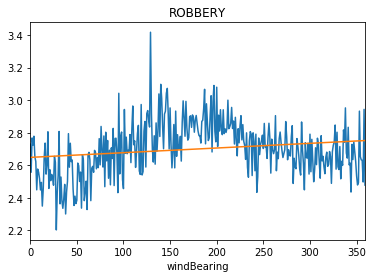

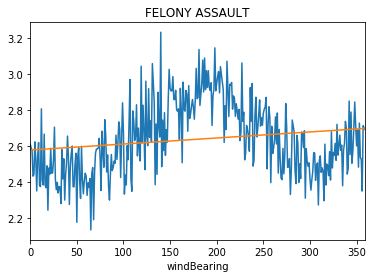

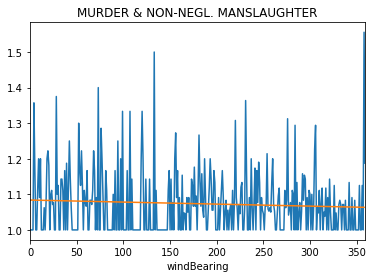

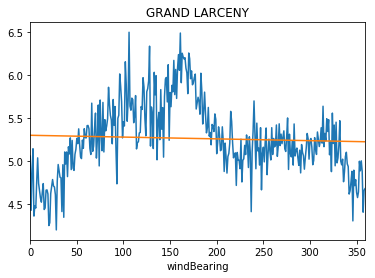

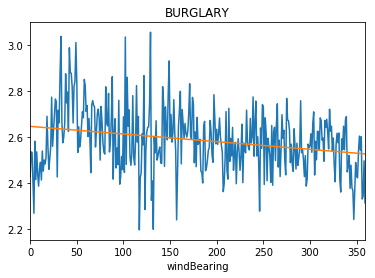

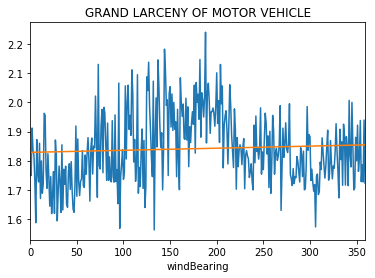

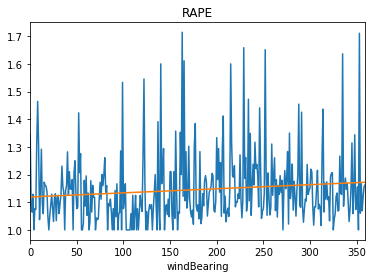

In [68]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'windBearing')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                  0.002784
Date:                Mon, 16 Apr 2018   Prob (F-statistic):              0.958
Time:                        14:35:21   Log-Likelihood:                -42.603
No. Observations:                  38   AIC:                             89.21
Df Residuals:                      36   BIC:                             92.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     12.



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     36.68
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           5.84e-07
Time:                        14:35:23   Log-Likelihood:                -38.615
No. Observations:                  38   AIC:                             81.23
Df Residuals:                      36   BIC:                             84.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.9

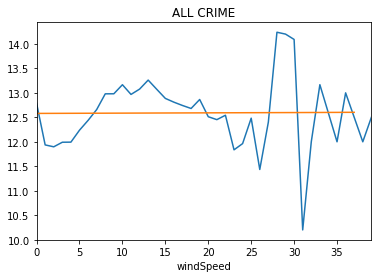

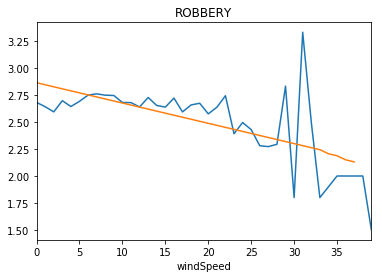

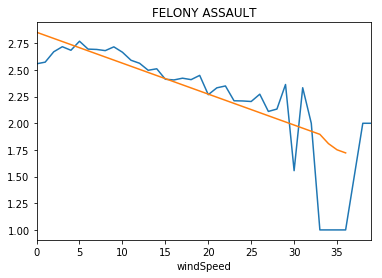

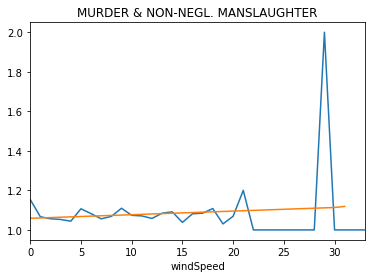

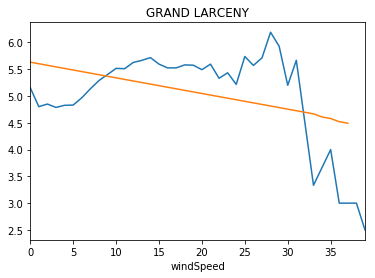

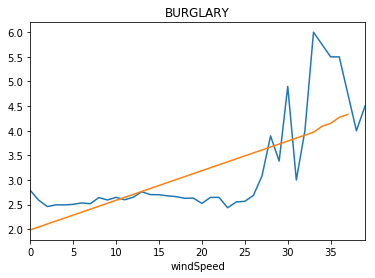

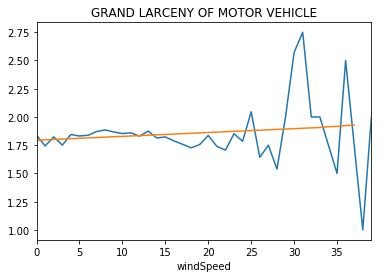

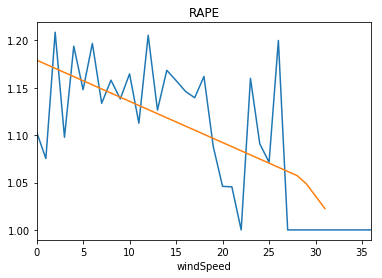

In [69]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'windSpeed')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     4.082
Date:                Mon, 16 Apr 2018   Prob (F-statistic):             0.0468
Time:                        14:35:25   Log-Likelihood:                -175.02
No. Observations:                  79   AIC:                             354.0
Df Residuals:                      77   BIC:                             358.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -10.



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     11.52
Date:                Mon, 16 Apr 2018   Prob (F-statistic):            0.00109
Time:                        14:35:27   Log-Likelihood:                -130.58
No. Observations:                  78   AIC:                             265.2
Df Residuals:                      76   BIC:                             269.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     24.9

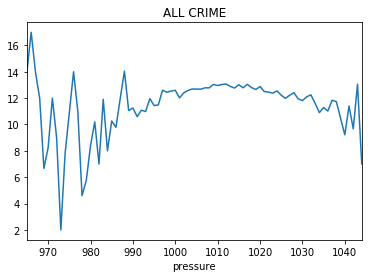

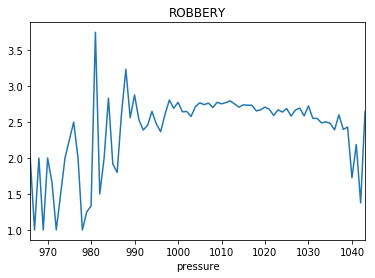

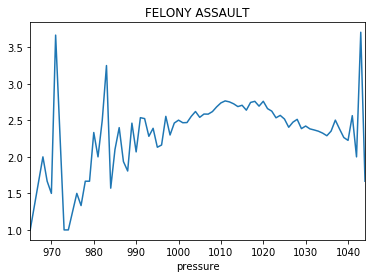

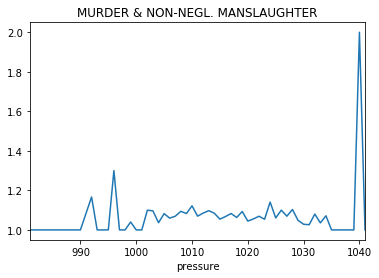

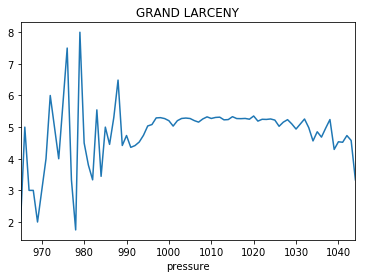

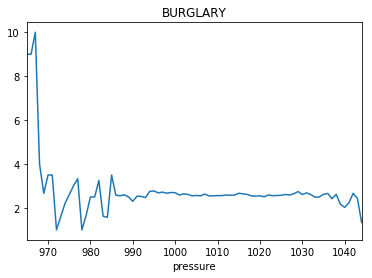

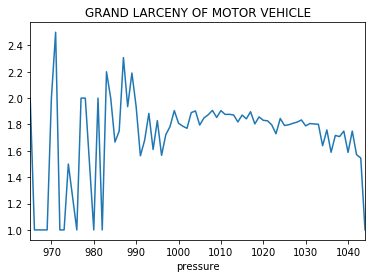

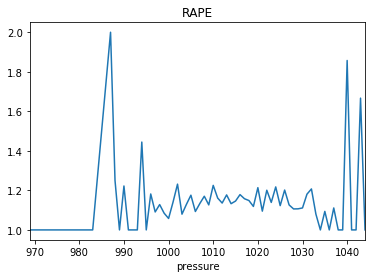

In [70]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'pressure')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     11.13
Date:                Mon, 16 Apr 2018   Prob (F-statistic):            0.00106
Time:                        14:35:29   Log-Likelihood:                -441.20
No. Observations:                 161   AIC:                             886.4
Df Residuals:                     159   BIC:                             892.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
I



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.833
Date:                Mon, 16 Apr 2018   Prob (F-statistic):             0.0945
Time:                        14:35:31   Log-Likelihood:                -191.91
No. Observations:                 144   AIC:                             387.8
Df Residuals:                     142   BIC:                             393.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
In

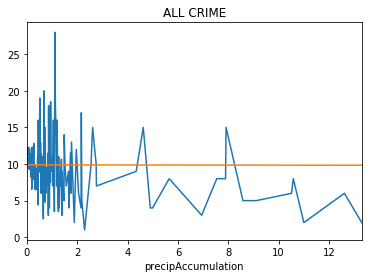

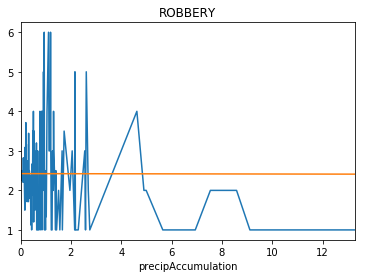

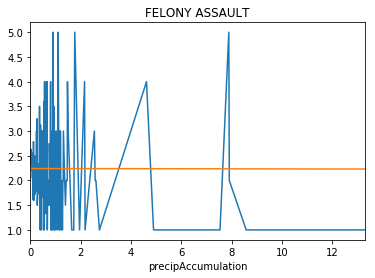

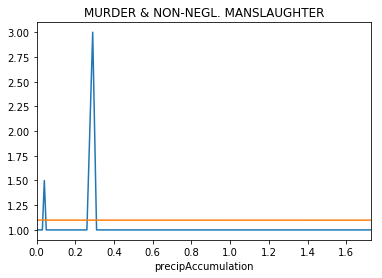

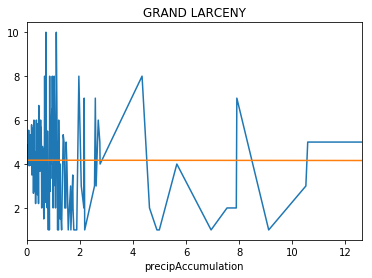

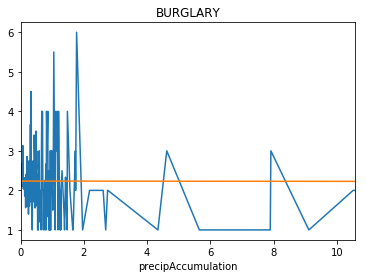

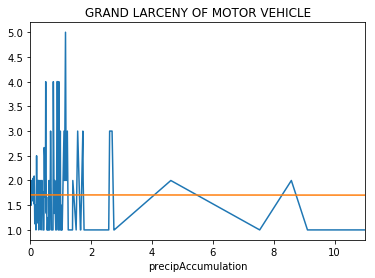

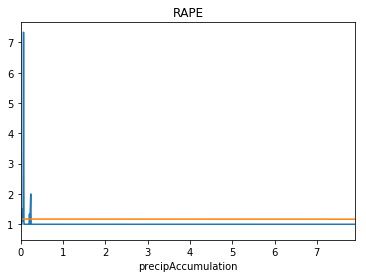

In [71]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'precipAccumulation')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     7.391
Date:                Mon, 16 Apr 2018   Prob (F-statistic):            0.00774
Time:                        14:35:33   Log-Likelihood:                -93.280
No. Observations:                 101   AIC:                             190.6
Df Residuals:                      99   BIC:                             195.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     12.



BURGLARY Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     48.29
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           3.95e-10
Time:                        14:35:36   Log-Likelihood:                 55.660
No. Observations:                 101   AIC:                            -107.3
Df Residuals:                      99   BIC:                            -102.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.5

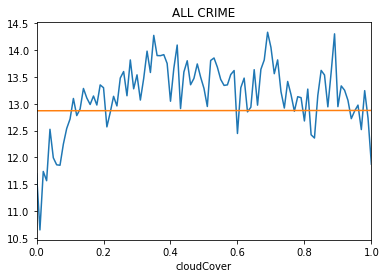

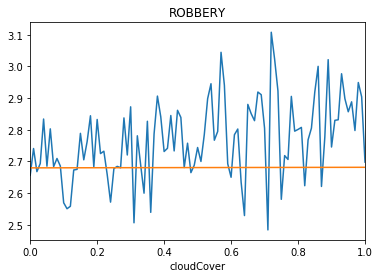

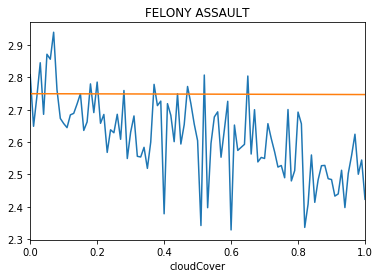

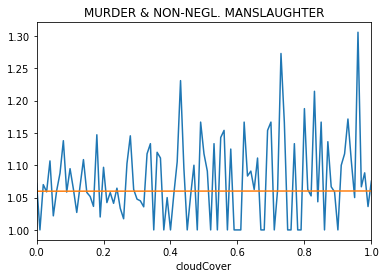

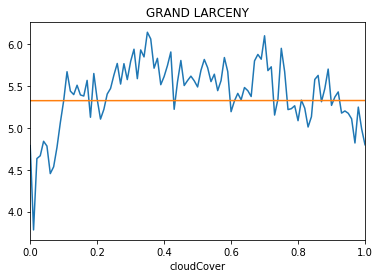

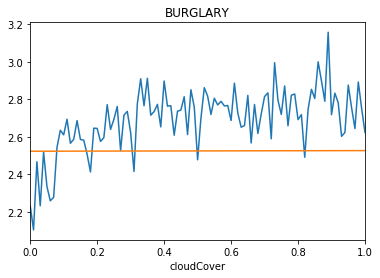

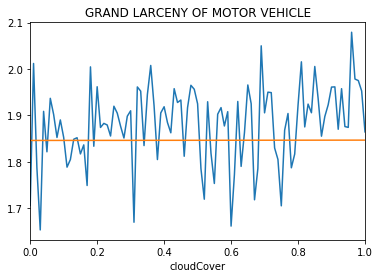

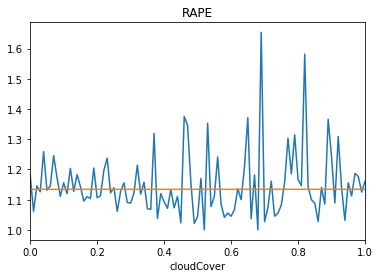

In [72]:
weatherTypes = ['dewPoint', 'apparentTemperature', 'temperature', 'visibility', 'precipIntensity',
                'windBearing', 'windSpeed', 'pressure', 'precipAccumulation', 'cloudCover']

for i in felonyTypes:
    weatherCorrelation(dfSeven, i, 'cloudCover')

# Reducing to outdoor crimes only

In [95]:
maybeOutdoor = ['STREET', 'PARK/PLAYGROUND', 'PARKING LOT/GARAGE (PUBLIC)', 'GAS STATION', 'TUNNEL',
       'TRANSIT - NYC SUBWAY', 'BUS (NYC TRANSIT)', 'PARKING LOT/GARAGE (PRIVATE)',
       'FERRY/FERRY TERMINAL', 'CONSTRUCTION SITE', 'BUS STOP', 'BRIDGE', 'OPEN AREAS (OPEN LOTS)', 'MARINA/PIER',
       'HIGHWAY/PARKWAY', 'BUS TERMINAL', 'CEMETERY', 'TRAMWAY']

outdoor = ['STREET', 'PARK/PLAYGROUND', 'TUNNEL', 'CONSTRUCTION SITE', 'BUS STOP', 'BRIDGE', 'OPEN AREAS (OPEN LOTS)',
           'MARINA/PIER', 'HIGHWAY/PARKWAY', 'BUS TERMINAL', 'CEMETERY']

dfSevenOutdoor = dfSeven.loc[dfSeven['PREM_TYP_DESC'].isin(maybeOutdoor)]

In [96]:
dfSevenOutdoor.head()

,level_0,index,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,...,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed,datetime_y,datetime_adj
2,12,12,898496564,12/31/2015,23:00:00,NaN,NaN,12/31/2015,109,GRAND LARCENY,...,NaN,1019.0,Clear,43.0,1.451621e+09,10.0,308.0,10.0,2016-01-01 04:00:00,2015-12-31 23:00:00
3,13,13,566081066,12/31/2015,23:00:00,NaN,NaN,12/31/2015,109,GRAND LARCENY,...,NaN,1019.0,Clear,43.0,1.451621e+09,10.0,308.0,10.0,2016-01-01 04:00:00,2015-12-31 23:00:00
9,34,34,590638275,12/31/2015,22:30:00,NaN,NaN,12/31/2015,106,FELONY ASSAULT,...,NaN,1019.0,Clear,43.0,1.451621e+09,10.0,308.0,10.0,2016-01-01 04:00:00,2015-12-31 23:00:00
11,38,38,448659551,12/31/2015,22:25:00,NaN,NaN,12/31/2015,106,FELONY ASSAULT,...,NaN,1019.0,Mostly Cloudy,44.0,1.451617e+09,10.0,313.0,13.0,2016-01-01 03:00:00,2015-12-31 22:00:00
12,40,40,221366121,12/31/2015,22:20:00,12/31/2015,22:30:00,12/31/2015,105,ROBBERY,...,NaN,1019.0,Mostly Cloudy,44.0,1.451617e+09,10.0,313.0,13.0,2016-01-01 03:00:00,2015-12-31 22:00:00


### There's an issue here where we cannot reset the index of the new dataframe... this is impacting the ability to run through the function we created, which requires the index to reset... for some reason, it DOES still work for certain types of crime (all, robbery, and felony assault)



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.114
Date:                Mon, 16 Apr 2018   Prob (F-statistic):              0.147
Time:                        16:00:50   Log-Likelihood:                -254.61
No. Observations:                 360   AIC:                             513.2
Df Residuals:                     358   BIC:                             521.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      

ValueError: zero-size array to reduction operation maximum which has no identity

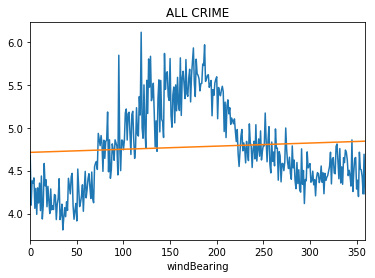

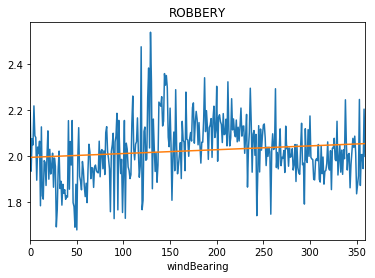

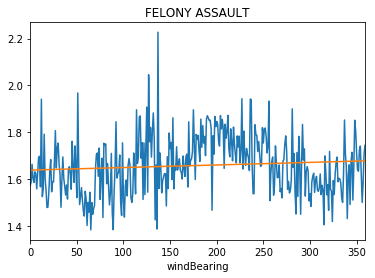

In [93]:
for i in felonyTypes:
    weatherCorrelation(dfSevenOutdoor, i, 'windBearing')



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.705
Date:                Mon, 16 Apr 2018   Prob (F-statistic):              0.192
Time:                        16:02:07   Log-Likelihood:                -286.68
No. Observations:                 360   AIC:                             577.4
Df Residuals:                     358   BIC:                             585.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1f7bd81e10>,
 [<matplotlib.lines.Line2D at 0x7f1f7bcbd510>])

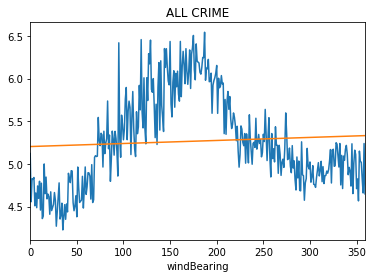

In [97]:
weatherCorrelation(dfSevenOutdoor, 'ALL CRIME', 'windBearing')

### Examining temperature and wind bearing for correlation

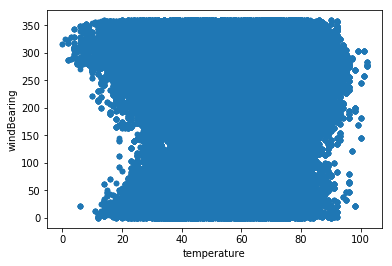

In [99]:
dfSeven.plot.scatter(x='temperature', y='windBearing');

This is kind of messy...let's take a random sampling of every 3000th row

In [110]:
dfSample = dfSeven.iloc[::3000, :]

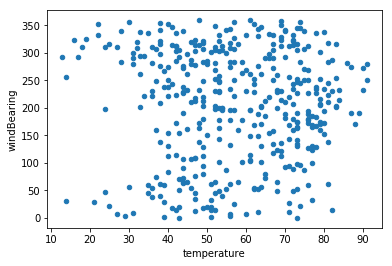

In [114]:
dfSample.plot.scatter(x='temperature', y='windBearing');

This shows us with a little more definition that southern winds are less likely to occur at lower temperatures. What would happen if we plot crimes that happen at 20 degrees (or higher), eliminating this hole?

In [112]:
dvSevenHigherTemps = dfSeven[(dfSeven['temperature'] >= 40)]

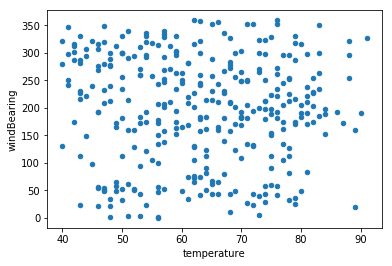

In [116]:
dfSevenHigherTempsSample = dvSevenHigherTemps.iloc[::3000, :]
dfSevenHigherTempsSample.plot.scatter(x='temperature', y='windBearing');

Still looks pretty randomly distributed to me...



ALL CRIME Regression Results:


                             OLS Regression Results                            
Dep. Variable:           CrimePerHour   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     17.81
Date:                Wed, 18 Apr 2018   Prob (F-statistic):           3.10e-05
Time:                        07:30:27   Log-Likelihood:                -439.79
No. Observations:                 360   AIC:                             883.6
Df Residuals:                     358   BIC:                             891.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1f7c262c50>,
 [<matplotlib.lines.Line2D at 0x7f1f7bf93b50>])

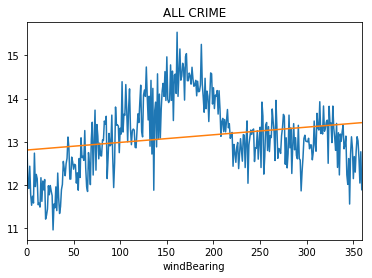

In [113]:
weatherCorrelation(dvSevenHigherTemps, 'ALL CRIME', 'windBearing')

Limiting our data to higher temperatures (as high as 40) still leaves us with a visible correlation... what else could account for this? Maybe it's a temporal correlation, with southern winds occuring more frequently in the summer.

## Time Series Analysis of wind bearing

In [117]:
weather.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed,datetime,datetime_adj
0,26.80,0.82,28.43,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1009.73,Mostly Cloudy,32.48,1136091600,8.84,335.0,6.00,2006-01-01 05:00:00,2006-01-01 00:00:00
1,27.04,0.77,28.32,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1010.35,Mostly Cloudy,32.33,1136095200,7.67,345.0,5.49,2006-01-01 06:00:00,2006-01-01 01:00:00
2,27.21,0.78,28.34,0.85,partly-cloudy-night,NaN,0.0,0.0,NaN,1011.40,Mostly Cloudy,32.29,1136098800,8.69,344.0,5.23,2006-01-01 07:00:00,2006-01-01 02:00:00
3,27.01,0.34,27.97,0.84,partly-cloudy-night,NaN,0.0,0.0,NaN,1012.17,Partly Cloudy,32.19,1136102400,8.79,345.0,5.32,2006-01-01 08:00:00,2006-01-01 03:00:00
4,26.65,0.95,28.10,0.85,cloudy,NaN,0.0,0.0,NaN,1012.67,Overcast,32.00,1136106000,8.41,339.0,5.49,2006-01-01 09:00:00,2006-01-01 04:00:00


In [129]:
dailyWeather = weather.iloc[::24, :]
dailyWeatherOneYear = dailyWeather.iloc[0:365]
dailyWeatherTwoYears = dailyWeather.iloc[0:730]
weeklyWeather = dailyWeather.iloc[::7, :]
weeklyWeatherOneyear = weeklyWeather.iloc[0:52]

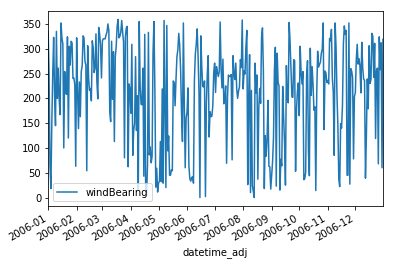

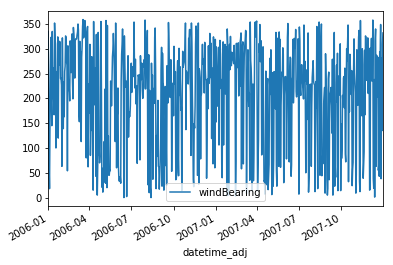

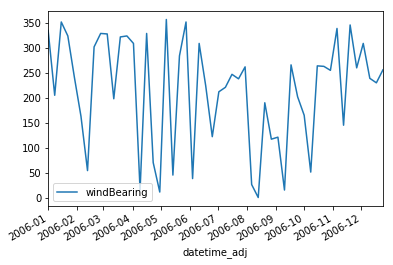

In [133]:
dailyWeatherOneYear.plot(x='datetime_adj', y='windBearing');
dailyWeatherTwoYears.plot(x='datetime_adj', y='windBearing');
weeklyWeatherOneyear.plot(x='datetime_adj', y='windBearing');

#### Looking at data for 365 continuous days, 730 continuous days, and 52 continuous weeks, there isn't a discernable temporal distribution of wind bearing. There are small holes here and there, but those do not appear to be based on any discernable pattern. 